# Imports

In [70]:
%load_ext autoreload
%autoreload 2

from agentlace.action import ActionServer, ActionConfig, ActionClient
import tensorflow as tf
import numpy as np
import utils
import matplotlib.pyplot as plt
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Robot Action Server

In [76]:
action_client = ActionClient(
            server_ip="localhost",
            config=utils.make_action_config("frodobot")
        )

DEBUG:root:Req-rep client is connecting to localhost:1111


In [81]:
for i in range(3):
    action_client.act("action_vw", np.array([0, -0.3]))
    time.sleep(0.2)

In [68]:
for i in range(20):
    action_client.act("action_vw", np.array([0.2, -0.3]))
    time.sleep(0.2)

DEBUG:root:WARNING: No res from server. reset socket.
DEBUG:root:WARNING: No res from server. reset socket.
DEBUG:root:WARNING: No res from server. reset socket.


KeyboardInterrupt: 

In [77]:
recent_obs = action_client.obs()

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'sRGB' 41 1
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 54 8192


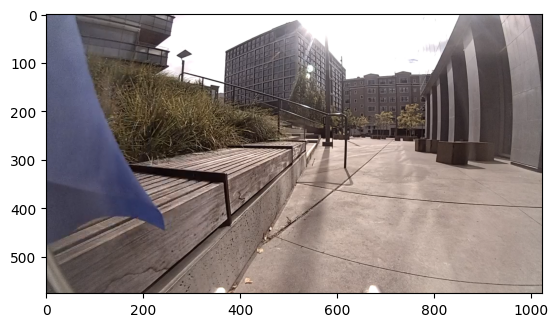

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'sRGB' 41 1
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 54 8192


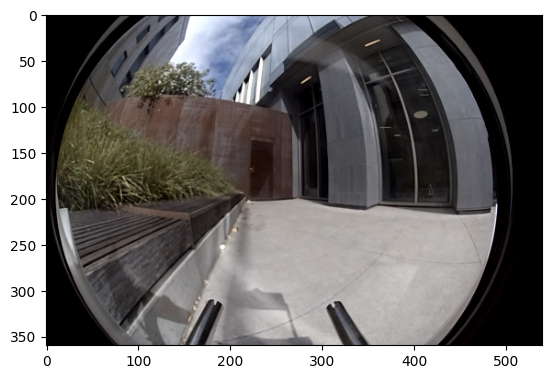

In [78]:
front_frame = utils.decode_from_base64(recent_obs["front_frame"])
plt.imshow(front_frame)
plt.show()
back_frame = utils.decode_from_base64(recent_obs["rear_frame"])
plt.imshow(back_frame)
plt.show()

In [ ]:
front_frame = utils.decode_from_base64(recent_obs["front_frame"])
plt.imshow(front_frame)